In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from matplotlib.ticker import MaxNLocator
import itertools

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import draft_functions as funk

In [2]:
initial_depth = -5000  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = [10] + [i for i in range(100, 501, 100)] + [ 1000, 10000]
sim_names = [10] + [i for i in range(100, 501, 100)] + [ 1000, 10000]

In [16]:
simulations = simulations[::-1]

In [17]:
surface_events = {}

for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_{ft}.zarr'
    sim = xr.open_zarr(local_path)

    # loading fields as np arrays to do some nasty indexing
    radiuses = sim['radius'].values
    depths = sim['z'].values
    latitudes = sim['lat'].values
    longitudes = sim['lon'].values
    frag_events = sim['frag_events'].values
    d_2_shore = sim['distance'].values

    df_sim = {}  # dictiorany to store data per sim. Could be a pandas DF

    # Detecting the index and the particles that reach the surface
    k1, k2 = np.where(depths < 30)
    idx_particles, idx_k2 = np.unique(k1, return_index=True)
    surface_time = k2[idx_k2]
    
    m1, m2 = np.where(radiuses > 1e-4)
    _, idx_m2 = np.unique(m1, return_index=True)
    time_fragmetation = m2[idx_m2]

    df_sim['particle_index'] = idx_particles
    df_sim['surface_time'] = surface_time  # Days. equivalent to index in simus
    df_sim['radius'] = radiuses[idx_particles, surface_time]
    df_sim['depths'] = depths[idx_particles, surface_time]
    df_sim['frag_events'] = frag_events[idx_particles, surface_time]
    df_sim['frag_time'] = time_fragmetation
    df_sim['d2shore'] = d_2_shore[idx_particles, surface_time]

    latz = latitudes[idx_particles, surface_time]
    lonz = longitudes[idx_particles, surface_time]
    xy_pos = (lonz, latz)

    df_sim['displacement'] = funk.haversine(origin, xy_pos)
    df_sim['lat'] = latz
    df_sim['lon'] = lonz

    surface_events[sim_names[k]] = df_sim  # Storing the dictionaris in another dict


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


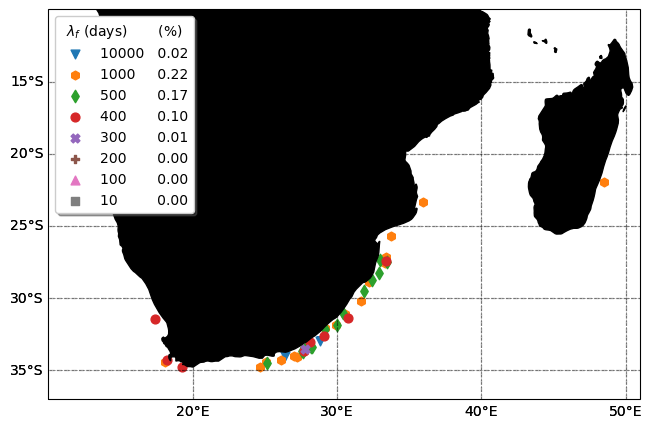

In [93]:
marker = itertools.cycle(('v', 'h', 'd', 'o', 'X', 'P', '^', 's'))

fig,ax = plt.subplots(figsize=(6,6),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([10, 51,-37, -10], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1, color='black')
# ax.add_feature(cfeature.COASTLINE)


shoreparticles = {}
fill_characters = [0, 2, 4,4,4,4,4,6]


for j, ft in enumerate(simulations[::-1]):
    shore_particles = np.where(surface_events[ft]['d2shore'] < 10)
    correction = np.where(surface_events[ft]['lon'][shore_particles] > 10)
    shore_particles = shore_particles[0][correction]
    proportion = len(shore_particles) / 2**13 * 100
    shoreparticles[ft] = len(shore_particles)

    
    ax.scatter(surface_events[ft]['lon'][shore_particles],
           surface_events[ft]['lat'][shore_particles], s=40, transform=ccrs.PlateCarree(), 
           label=f"{ft} {' '*fill_characters[j]}  {proportion:.2f}", marker=next(marker))
    

handles, labels = ax.get_legend_handles_labels()


ax.legend(shadow=True, title='$\lambda_f$ (days)       (%)', loc='upper left')


In [107]:
Stats_surface = {}

for j, ft in enumerate(simulations[::-1]):
    number_surface = len(surface_events[ft]['particle_index'])/2**13*100
    fraction_shore = shoreparticles[ft]/2**13*100
    
    Stats_surface[ft] = [number_surface, fraction_shore]
    print(ft, ' '*fill_characters[j], number_surface, ' '*fill_characters[j], fraction_shore)

10000  4.8095703125  0.0244140625
1000    86.77978515625    0.2197265625
500      99.3408203125      0.1708984375
400      99.86572265625      0.09765625
300      99.9755859375      0.01220703125
200      100.0      0.0
100      100.0      0.0
10        100.0        0.0


In [110]:
pd.DataFrame(Stats_surface, index=['Number of particles at surface (%)', 'Number of particles at shore (%)']).T

,Number of particles at surface (%),Number of particles at shore (%)
10000,4.809570,0.024414
1000,86.779785,0.219727
500,99.340820,0.170898
400,99.865723,0.097656
300,99.975586,0.012207
200,100.000000,0.000000
100,100.000000,0.000000
10,100.000000,0.000000


In [88]:
surface_events[ft]['particle_index']

array([   0,   45,   49,   55,   64,  112,  114,  149,  165,  201,  218,
        253,  284,  306,  335,  376,  377,  378,  394,  401,  420,  439,
        451,  459,  488,  502,  506,  516,  576,  586,  589,  590,  665,
        685,  695,  706,  711,  719,  720,  750,  775,  779,  813,  823,
        839,  843,  848,  867,  868,  874,  896,  904,  927,  931,  936,
        944,  992, 1089, 1142, 1157, 1160, 1187, 1203, 1209, 1215, 1246,
       1258, 1312, 1313, 1323, 1337, 1353, 1356, 1372, 1383, 1406, 1409,
       1420, 1427, 1453, 1462, 1510, 1518, 1582, 1588, 1618, 1631, 1651,
       1657, 1670, 1712, 1713, 1716, 1718, 1758, 1759, 1764, 1786, 1797,
       1805, 1807, 1829, 1837, 1841, 1844, 1858, 1875, 1887, 1897, 1905,
       1937, 1967, 1970, 1978, 2001, 2045, 2105, 2172, 2199, 2207, 2214,
       2230, 2250, 2291, 2296, 2312, 2328, 2346, 2353, 2366, 2381, 2393,
       2407, 2410, 2441, 2468, 2470, 2473, 2482, 2499, 2510, 2552, 2556,
       2559, 2565, 2577, 2591, 2603, 2628, 2646, 26

In [60]:
len(str(ft))

2

In [26]:
shoreparticles

{'10000': 2,
 '1000': 18,
 '500': 14,
 '400': 8,
 '300': 1,
 '200': 0,
 '100': 0,
 '10': 0}

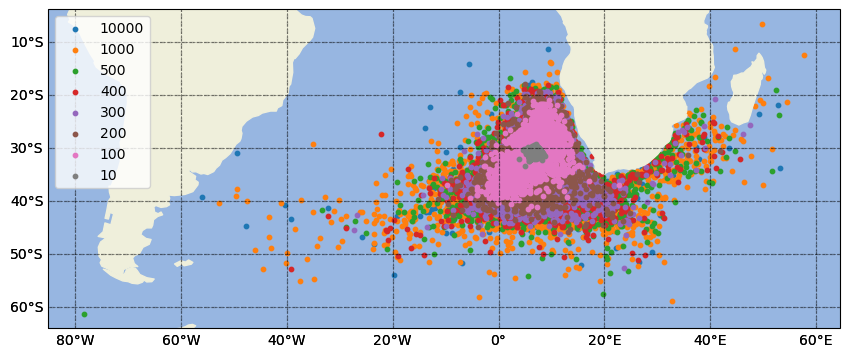

In [65]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

for ft in simulations[::-1]:
    ax.scatter(surface_events[ft]['lon'],
           surface_events[ft]['lat'], s=10, transform=ccrs.PlateCarree(), label=ft)

ax.legend()

In [6]:
def find_badparticle(dataset, ref_field):
    a = dataset['trajectory'][:,0].where(dataset[ref_field][:,-1]<1).values
    _traj = np.int32(a[~np.isnan(a)])
    return _traj

In [7]:
find_badparticle(sim, 'abs_salinity')

array([    1,     4,    10, ..., 49979, 49983, 49998], dtype=int32)

In [8]:
a = sim['trajectory'][:,0].where(sim['abs_salinity'][:,2000]<1).values

In [9]:
weird_traj = np.int32(a[~np.isnan(a)])

In [14]:
sim['lon'][weird_traj[0:5], 0]

<xarray.DataArray 'lon' (traj: 5)>
array([6.30312835, 6.28702691, 6.27152917, 6.30336548, 6.30242295])
Dimensions without coordinates: traj
Attributes:
    long_name:      
    standard_name:  longitude
    units:          degrees_east
    axis:           X

In [37]:
time_dim = 3651

sal_under_1 = np.zeros(time_dim)
temp_under_1 = np.zeros(time_dim)
stuck = np.zeros(time_dim)
# _temp = np.zeros(time_dim)
no_movement = np.diff(sim['lon'], axis=1)

for t in range(time_dim-1):
    sal_under_1[t] = (sim['abs_salinity'][:,t]<1).values.sum()
    temp_under_1[t] = (sim['cons_temperature'][:,t]<=0).values.sum()
#     _temp = (sim['cons_temperature'][:,t]<0).values.sum()
    stuck[t] = (no_movement[:, t] == 0).sum()

Text(0, 0.5, 'Number of particles')

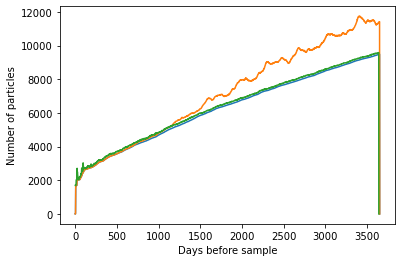

In [38]:
plt.plot(sal_under_1)
plt.plot(temp_under_1)
plt.plot(stuck[10:])
plt.xlabel('Days before sample')
plt.ylabel('Number of particles')

In [39]:
time_dim = 3651

stuck_lon = np.zeros(time_dim)
stuck_lat = np.zeros(time_dim)
stuck_z = np.zeros(time_dim)

acc_lon = np.diff(sim['lon'], axis=1)
acc_lat = np.diff(sim['lat'], axis=1)
acc_z = np.diff(sim['z'], axis=1)

for t in range(time_dim-1):
    stuck_lon[t] = (acc_lon[:, t] == 0).sum()
    stuck_z[t] = (acc_z[:, t] == 0).sum()
    stuck_lat[t] = (acc_lat[:, t] == 0).sum()

Text(0, 0.5, 'Number of particles')

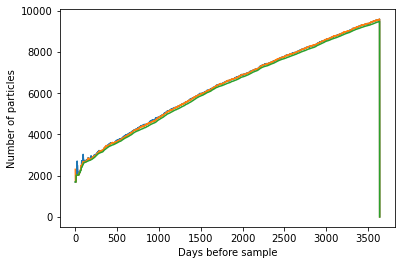

In [40]:
plt.plot(stuck_lon[10:])
plt.plot(stuck_lat[10:])
plt.plot(stuck_z[10:])
plt.xlabel('Days before sample')
plt.ylabel('Number of particles')

In [74]:
c = (acc_lon + acc_lat + acc_z)
c = ~(c == 0)

In [75]:
np.where(c == True)

(array([    0,     0,     0, ..., 49999, 49999, 49999]),
 array([   0,    1,    2, ..., 3647, 3648, 3649]))

In [153]:
def stuck_particles_mask(dataset):
    time = dataset.dims['obs']

    diff_lon = np.roll(dataset['lon'], axis=1, shift=1) - dataset['lon']
    diff_lat = np.roll(dataset['lat'], axis=1, shift=1) - dataset['lat']
    diff_z = np.roll(dataset['z'], axis=1, shift=1) - dataset['z']
    
    mask = (diff_lon + diff_lat + diff_z)
    mask = ~(mask == 0)
    
    return mask

In [133]:
msk = stuck_particles_mask(sim)

In [134]:
stuck_particles = 50000 - np.sum(msk, axis=0)

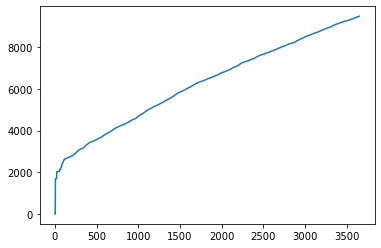

In [135]:
plt.plot(stuck_particles)

In [136]:
sim_masked = sim.where(msk == True)

In [137]:
(sim_masked['abs_salinity'] < 1).sum()

<xarray.DataArray 'abs_salinity' ()>
array(9490)

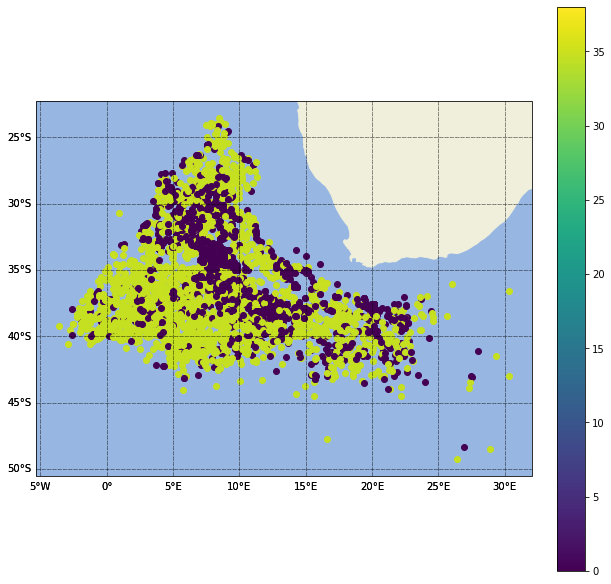

In [124]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in weird_traj:
    im = ax.scatter(sim['lon'][i, n], sim['lat'][i,n], c=sim['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

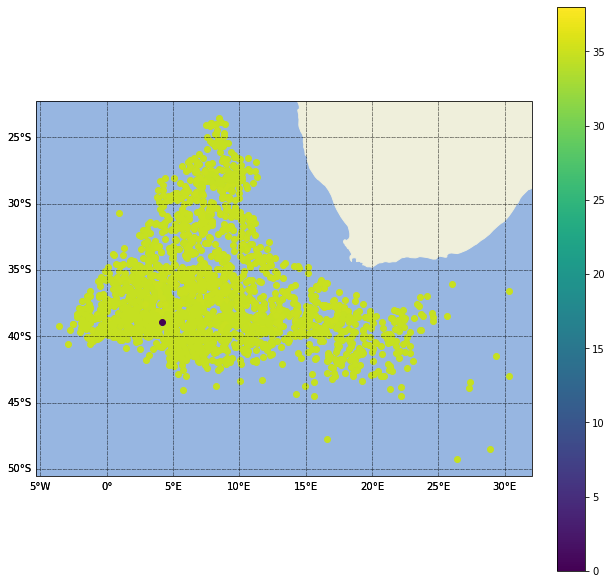

In [125]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in weird_traj:
    im = ax.scatter(sim_masked['lon'][i, n], sim_masked['lat'][i,n], c=sim_masked['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

#### sim60

In [138]:
sim60 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_60m_t3650_diff-False.nc')

In [154]:
masked_60 = stuck_particles_mask(sim60)

In [155]:
sim60_masked = sim60.where(masked_60 == True)

In [149]:
w_idx = find_badparticle(sim60, 'abs_salinity')

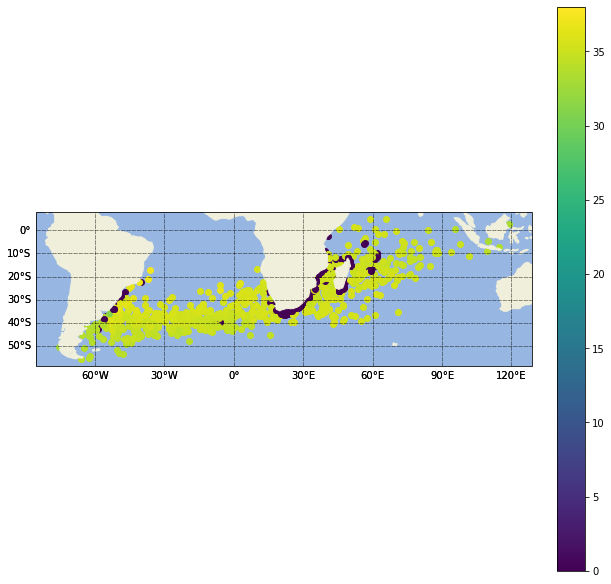

In [151]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in w_idx:
    im = ax.scatter(sim60['lon'][i, n], sim60['lat'][i,n], c=sim60['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)

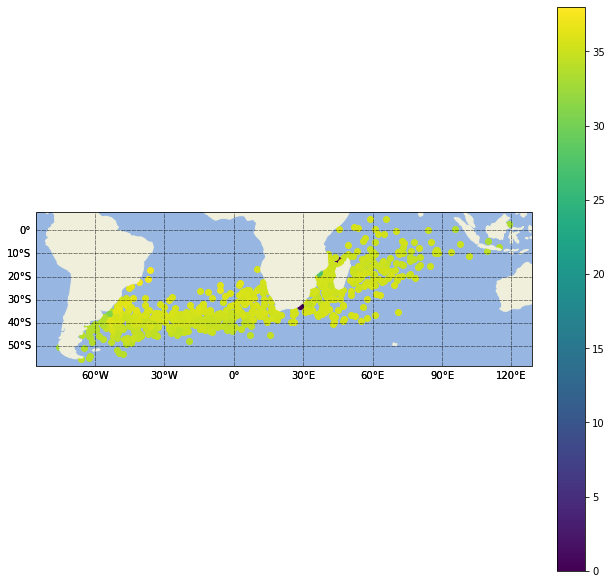

In [156]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1)
# ax.add_feature(cfeature.COASTLINE)

n = 1000
for i in w_idx:
    im = ax.scatter(sim60_masked['lon'][i, n], sim60_masked['lat'][i,n], c=sim60_masked['abs_salinity'][i,n], vmin=0, vmax=38);

plt.colorbar(im)